# Lab04 Task 2-1: Post-Training Static Quantization Using Pytorch's FX Graph Mode

In this notebook, we will attempt to apply post-training static quantization to the model using the PyTorch's FX graph mode.

<font color="red">**Only add or modify code between `YOUR CODE START` and `YOUR CODE END`. Don’t change anything outside of these markers.**</font>

In [24]:
##### YOUR CODE START #####

# Please fill in your student id here.
student_id = "313510156"

##### YOUR CODE END #####

### Library Import

The libraries you need for this practice are listed below. You can add more if you think they’re necessary. If you’re not sure whether a library is allowed, ask TA in the FB group.

In [25]:
import os
import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
import copy
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx
from torch.ao.quantization import QConfigMapping, get_default_qconfig
import matplotlib
import matplotlib.pyplot as plt

##### YOUR CODE START #####

# Do you need any additional libraries? If not, you can leave this block empty.

##### YOUR CODE END #####

### Device

This notebook must be run on a CPU, as CUDA lacks support for computations with the quint8 data type. Since this notebook doesn't involve any model training, it will not take much time to execute on a CPU.

In [26]:
device = 'cpu'

### Dataset

In this lab, we will use CIFAR-10 dataset. CIFAR-10 is a widely used image classification dataset consisting of 60,000 color images at 32×32 resolution. It has 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck), with 50,000 training images and 10,000 test images. Due to its small size and balanced categories, CIFAR-10 is commonly used for benchmarking machine learning and computer vision models.

CIFAR-10 has both a training set and a test set. Post-training static quantization requires a small subset of the training set for calibration. On the other hand, manually quantizing the convolutional layer weights is a data-free process. The test set is only used at the end to evaluate the final result.

In [27]:
# Load training & test set

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010))
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                         shuffle=False)

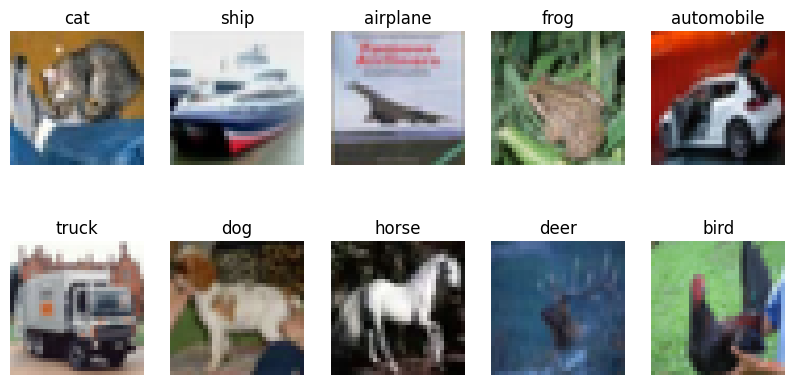

In [28]:
# Let's see some image samples in CIFAR-10 dataset.

def show_img():
    classes = ['airplane','automobile','bird','cat','deer',
           'dog','frog','horse','ship','truck']
    seen = set()
    images = []
    labels = []
    for img, label in testset:
        if label not in seen:
            seen.add(label)
            images.append(img)
            labels.append(classes[label])
        if len(seen) == len(classes):
            break
    mean = torch.tensor([0.4914, 0.4822, 0.4465])
    std = torch.tensor([0.2023, 0.1994, 0.2010])
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i, ax in enumerate(axes.flatten()):
        img = images[i] * std.view(3,1,1) + mean.view(3,1,1)
        img = img.clamp(0, 1)
        img = img.permute(1, 2, 0)
        ax.imshow(img.cpu().numpy())
        ax.set_title(labels[i])
        ax.axis("off")
    plt.show()

show_img()

### Load Model

In this lab, you do not need to train a model from scratch. We will use a pretrained ResNet20 model instead. ResNet20 is a popular deep learning model for image classification. Its key feature is the use of skip (residual) connections, which make training deep networks easier and more stable.
The code below loads the pre-trained model and evaluates its accuracy on the test set, which should be <font color="red">**92.60%**</font>. Please use this model for the subsequent tasks. <font color="red">**Designing and training your own model is not allowed.**</font>

In [29]:
model = torch.hub.load('chenyaofo/pytorch-cifar-models', 
                       'cifar10_resnet20', pretrained=True).to(device)
model.eval()

Using cache found in /home/bschen/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [30]:
def test_acc(model_test):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model_test(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f'Accuracy on CIFAR-10 test set: {acc:.2f}%')
    return acc
    
_ = test_acc(model)

Accuracy on CIFAR-10 test set: 92.60%


### Post-Training Static Quantization Using Pytorch's FX Graph Mode

**Post-training static quantization** using PyTorch's **FX graph mode** is a streamlined process. It begins with `prepare_fx`, which traces the floating-point model and inserts observer modules to analyze the range of activations. Next, the model is **calibrated** by feeding it a small amount of representative data, allowing the observers to gather statistics. Finally, `convert_fx` uses these statistics to transform the model into a highly efficient, quantized integer-based version ready for inference. The following cells will show you how to quantize a model using this function.

#### 1. Prepare the Model

First, we use `prepare_fx` to trace the floating-point model. This function analyzes the model's structure, fuses operations (like Conv-BN-ReLU), and inserts **"observer"** modules into the model graph. These observers are responsible for collecting statistics about the data distributions (e.g., min/max values) that flow through different layers.

In [31]:
# Set the backend engine for quantized operations.
# 'fbgemm' (Facebook General Matrix-Matrix Multiplication) is a highly optimized 
# backend for x86 CPUs. Other options like 'qnnpack' exist for ARM CPUs.
# This choice determines which library will execute the low-level integer computations.
torch.backends.quantized.engine = "fbgemm"

# Define the quantization configuration using a QConfigMapping.
# This mapping object tells PyTorch how to quantize different parts of the model.
# .set_global() applies the same configuration to the entire model.
# torch.quantization.default_qconfig is a standard, pre-defined configuration that uses:
# - MinMaxObserver for activations (to track min/max values).
# - Per-tensor affine quantization for weights.
# This is a good starting point for most models.
qconfig_mapping = QConfigMapping().set_global(torch.quantization.default_qconfig)

# Prepare an example input tensor.
# The `prepare_fx` function requires a sample input to "trace" the model's forward pass.
# It uses this trace to understand the model's architecture and build a computational graph (an FX Graph).
# The data inside the tensor doesn't matter, but its shape and type are important for tracing.
# Here, we are just taking the first sample from the training set.
example_input = (trainset[0])

model_prepared = copy.deepcopy(model)

# Prepare the model for quantization using the FX graph mode.
# This is the first major step in the quantization workflow.
# `prepare_fx` takes the model, the quantization configuration, and the example input.
# It does two key things:
#   1. Fuses operations: It combines layers that are often executed together (like Conv -> BatchNorm -> ReLU) 
#      into a single, more efficient operation.
#   2. Inserts Observers: It places "observer" modules into the model's graph. These observers will watch 
#      the data that flows through the model during calibration to collect statistics (like min/max values).
model_prepared = prepare_fx(
    model_prepared, 
    qconfig_mapping,
    example_input
)

model_prepared.eval()

/tmp/ipykernel_1634416/850800968.py:33: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_prepared = prepare_fx(


GraphModule(
  (activation_post_process_0): MinMaxObserver(min_val=inf, max_val=-inf)
  (conv1): ConvReLU2d(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (activation_post_process_1): MinMaxObserver(min_val=inf, max_val=-inf)
  (layer1): Module(
    (0): Module(
      (conv1): ConvReLU2d(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (1): Module(
      (conv1): ConvReLU2d(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (2): Module(
      (conv1): ConvReLU2d(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

#### 2. Calibrate the Model

Next, we run a small, representative sample of the training data through the prepared model. This "calibration" step allows the observers to gather the necessary statistics. The collected data is crucial for determining the optimal quantization parameters (scale and zero-point) for converting the floating-point tensors into a lower-precision format like INT8.

In [32]:
with torch.no_grad():
    for images, _ in trainloader:
        images = images.to(device)
        model_prepared(images)

#### 3. Convert the Model

Finally, we call `convert_fx` on the calibrated model. This function uses the statistics gathered by the observers to remove them and replace the floating-point operations with their quantized integer-based equivalents. The result is a fully quantized, more efficient model ready for inference.

In [33]:
model_api = convert_fx(model_prepared)
model_api.eval()

/tmp/ipykernel_1634416/715140412.py:1: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_api = convert_fx(model_prepared)


GraphModule(
  (conv1): QuantizedConvReLU2d(3, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.032696682959795, zero_point=0, padding=(1, 1))
  (layer1): Module(
    (0): Module(
      (conv1): QuantizedConvReLU2d(16, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.029086552560329437, zero_point=0, padding=(1, 1))
      (conv2): QuantizedConv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.06580246239900589, zero_point=66, padding=(1, 1))
    )
    (1): Module(
      (conv1): QuantizedConvReLU2d(16, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.021775588393211365, zero_point=0, padding=(1, 1))
      (conv2): QuantizedConv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.05116340145468712, zero_point=49, padding=(1, 1))
    )
    (2): Module(
      (conv1): QuantizedConvReLU2d(16, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.016928987577557564, zero_point=0, padding=(1, 1))
      (conv2): QuantizedConv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.06175434589385986, zer

In [34]:
_ = test_acc(model_api)

Accuracy on CIFAR-10 test set: 92.13%


### Exercise: Investigating the Impact of Calibration Dataset Size

You should now be familiar with how to perform quantization using PyTorch's FX graph mode. Now, please quantize the model again using this method. In the example above, we used the entire training set for calibration, but this time you are required to use <font color="red">**at least five different amounts of data.**</font> Compare the changes in accuracy of the quantized models on the test set, and <font color="red">**document your observations in your report.**</font>

Using cache found in /home/bschen/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
/tmp/ipykernel_1634416/3837223287.py:54: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_prepared = prepare_fx(model_prepared, qconfig_mapping, example_input.unsqueeze(0).to(device))
/tmp/ipykernel_1634416/3837223287.py:63: DeprecationWarning: torch.ao.quantization is deprecated 


Calibration Data Size    MinMax         Histogram      MovingAverageMinMax
--------------------------------------------------------------------------------
5000                     92.26          92.16          92.24          
10000                    92.06          92.14          92.15          
15000                    92.27          92.10          92.26          
20000                    92.29          92.17          92.11          
25000                    92.39          92.19          92.22          
30000                    92.13          92.28          92.22          
35000                    92.28          92.28          92.17          
40000                    92.16          92.27          92.15          
45000                    92.17          92.21          92.21          
50000                    92.13          92.31          92.30          



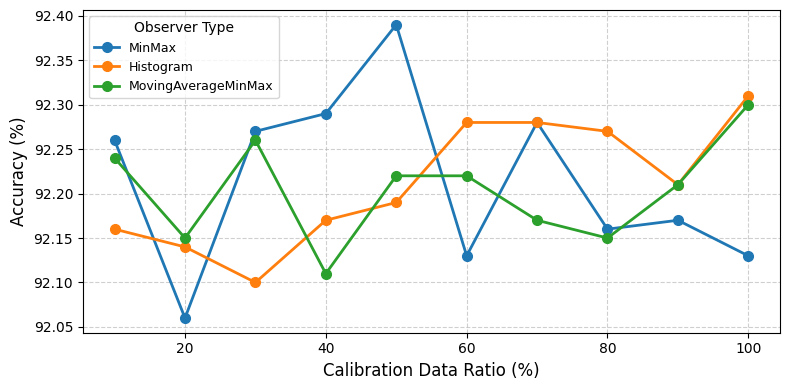

In [39]:
##### YOUR CODE START #####

# Hyperparameters
TRAIN_RATIO_LIST = torch.arange(0.1, 1.1, 0.1)
BATCH_SIZE = 128
device = "cpu"

# Observers to test
observers = {
    "MinMaxObserver": torch.quantization.default_observer,  # same as your current
    "HistogramObserver": torch.quantization.HistogramObserver,
    "MovingAverageMinMaxObserver": torch.quantization.MovingAverageMinMaxObserver
}

cal_sizes = []
results = {name: [] for name in observers.keys()}

# Define test function
def test_acc(model_api):
    model_api.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_api(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

for train_ratio in TRAIN_RATIO_LIST:
    train_size = int(len(trainset) * train_ratio)
    val_size = len(trainset) - train_size
    train_subset, _ = torch.utils.data.random_split(trainset, [train_size, val_size])
    trainloader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)

    cal_sizes.append(train_size)

    for obs_name, obs_func in observers.items():
        # Load pretrained model
        model = torch.hub.load('chenyaofo/pytorch-cifar-models', 'cifar10_resnet20', pretrained=True).to(device)
        model.eval()

        # Prepare quantization config
        torch.backends.quantized.engine = "fbgemm"
        qconfig = torch.ao.quantization.QConfig(
            activation=obs_func.with_args(reduce_range=False),
            weight=torch.quantization.default_weight_observer
        )
        qconfig_mapping = QConfigMapping().set_global(qconfig)

        example_input, _ = trainset[0]
        model_prepared = copy.deepcopy(model)
        model_prepared = prepare_fx(model_prepared, qconfig_mapping, example_input.unsqueeze(0).to(device))
        model_prepared.eval()

        # Calibration
        with torch.no_grad():
            for images, _ in trainloader:
                images = images.to(device)
                model_prepared(images)

        model_quantized = convert_fx(model_prepared)
        model_quantized.eval()

        # Evaluate
        acc = test_acc(model_quantized)
        results[obs_name].append(acc)

# Print results summary
print(f"\n{'=' * 80}")
print(f"{'Calibration Data Size':<25}", end="")
for obs_name in observers.keys():
    print(f"{obs_name.replace('Observer', ''):<15}", end="")
print(f"\n{'-' * 80}")

for i, cal_size in enumerate(cal_sizes):
    print(f"{cal_size:<25}", end="")
    for obs_name in observers.keys():
        print(f"{results[obs_name][i]:<15.2f}", end="")
    print()
print(f"{'=' * 80}\n")

# Plotting the results
plt.figure(figsize=(8, 4))
for obs_name, acc_list in results.items():
    plt.plot(
        [r * 100 for r in TRAIN_RATIO_LIST],
        acc_list,
        marker='o',
        linewidth=2,
        markersize=7,
        label=obs_name.replace('Observer', ''),
    )

# plt.title("PTQ Accuracy vs Calibration Data Ratio", fontsize=14)
plt.xlabel("Calibration Data Ratio (%)", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Observer Type", fontsize=9)
plt.tight_layout()
plt.show()

##### YOUR CODE END #####